In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import regex as re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten,  Layer, Input, Bidirectional, LSTM, LayerNormalization, Attention, TimeDistributed, concatenate
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from keras import activations
from sklearn.feature_selection import SelectKBest, chi2
import keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.optimizers import Adam
from keras.models import Model
import nltk
from gensim.models import KeyedVectors
import string
!pip install keras_tuner
import keras_tuner as kt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, average_precision_score
import scipy

Mounted at /content/drive
     |████████████████████████████████| 98 kB 5.8 MB/s 


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2022-03-19 16:18:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  47.5MB/s    in 27s     

2022-03-19 16:19:13 (46.6 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
df = pd.read_csv("drive/MyDrive/IMDB Dataset.csv")
df = df.sample(10000, random_state=42)
df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [ ]:
df.loc[df.review.isna()]  # 0 NaN values

,review,sentiment


In [ ]:
df.iloc[0,0]

"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended th

In [ ]:
df['review'] = df.review.str.replace(r'<br /><br />', ' ')  # replace <br /><br /> with a whitespace

In [ ]:
stop_words = Counter(stopwords.words('english'))  # faster look-up if dictionary
stop_words.pop("not")
stop_words.pop("no")

def review_cleaner(review, stop_words):
    review = re.sub(r"[^a-zA-Z]", " ", review)
    review = re.sub(r'\s+', ' ', review, flags=re.I)  # flags to ignore case
    reduced_review = [word for word in review.lower().split() if word not in stop_words and len(word) > 1]
    return ' '.join(reduced_review)

In [ ]:
df['review'] = df.review.apply(lambda x: review_cleaner(x, stop_words))

In [ ]:
df.iloc[0, 0]

'really liked summerslam due look arena curtains look overall interesting reason anyways could one best summerslam ever wwf lex luger main event yokozuna time ok huge fat man vs strong man glad times changed terrible main event like every match luger terrible matches card razor ramon vs ted dibiase steiner brothers vs heavenly bodies shawn michaels vs curt hening event shawn named big monster body guard diesel irs vs kid bret hart first takes doink takes jerry lawler stuff harts lawler always interesting ludvig borga destroyed marty jannetty undertaker took giant gonzalez another terrible match smoking gunns tatanka took bam bam bigelow headshrinkers yokozuna defended world title lex luger match boring terrible ending however deserves'

In [ ]:
df.sentiment.replace({'positive': 1, 'negative': 0}, inplace=True)
df.head()

,review,sentiment
33553,really liked summerslam due look arena curtain...,1
9427,not many television shows appeal quite many di...,1
199,film quickly gets major chase scene ever incre...,0
12447,jane austen would definitely approve one gwyne...,1
39489,expectations somewhat high went see movie thou...,0


### Dataset Exploration

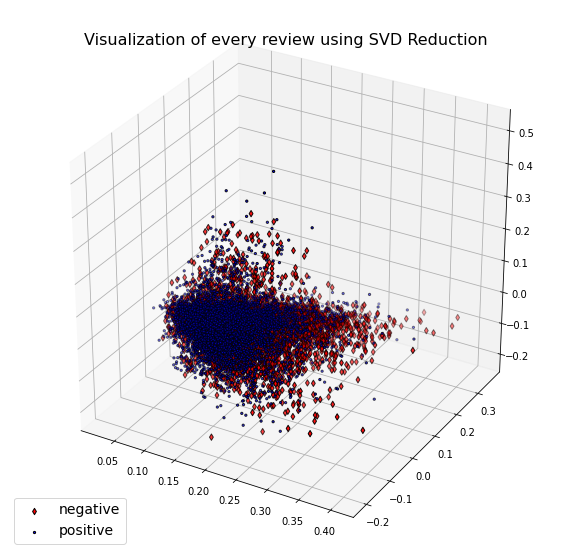

In [ ]:
X_Total = TfidfVectorizer().fit_transform(df.review.tolist())  # tfidf the whole dataset
svd = TruncatedSVD(n_components=3)  # Svd and only keep three columns
svd_x = svd.fit_transform(X_Total)

fig = plt.figure(figsize=(10,10))
fig.patch.set_alpha(1)

ax= fig.add_subplot(111, projection='3d')
ax.scatter(svd_x[df.sentiment.to_numpy()==0,0], svd_x[df.sentiment.to_numpy()==0 ,1], svd_x[df.sentiment.to_numpy()==0,2], 
            c='r', edgecolor='k', marker='d', label='negative')
ax.scatter(svd_x[df.sentiment.to_numpy()==1,0], svd_x[df.sentiment.to_numpy()==1 ,1], svd_x[df.sentiment.to_numpy()==1,2], 
            c='b', edgecolor='k', marker='.', label='positive')
ax.set_title('Visualization of every review using SVD Reduction', fontsize=16)
ax.legend(fontsize=14, loc='lower left')

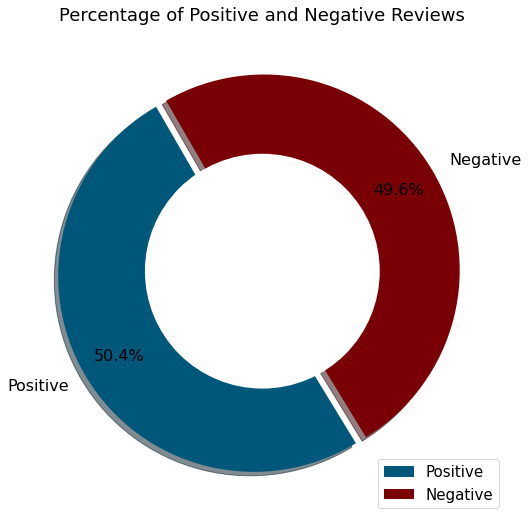

In [ ]:
fig = plt.figure(figsize=(10,9))
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

labels = ['Positive', 'Negative']
colors = ['#005779', '#790005']
ax.pie(df.sentiment.value_counts().tolist(), colors=colors, autopct='%.1f%%', labels=labels,
        pctdistance=0.8, textprops={'fontsize': 16}, startangle=120, shadow=0.9, explode=(0.05,0.01))
ax.legend(labels, loc='lower right', fontsize=15)
ax.set_title('Percentage of Positive and Negative Reviews', fontsize=18)

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

In [ ]:
vocab_size = len(set([word for sent in df.review.tolist() for word in sent.split()]))
print(f'The dataset contains {len(df.review.tolist())} reviews and {vocab_size} unique words (after cleaning).')

n_words = [len(sent.split()) for sent in df.review.tolist()]
avg_review_len = np.mean(n_words)
std_review_len = np.std(n_words)
print(f'The average number of words in a review is {round(avg_review_len)} with a standard deviation of {round(std_review_len)}')

The dataset contains 10000 reviews and 51452 unique words (after cleaning).
The average number of words in a review is 120 with a standard deviation of 90


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.review, df.sentiment, test_size=0.3, random_state=0)
X_dev, X_test, y_dev, y_test = train_test_split(X_val, y_val, test_size=0.7, random_state=0)

### Baselines

#### Logistic Regression

In [ ]:
lr = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=False, ngram_range=(1,1))),
    ('kbest', SelectKBest(score_func=chi2, k=5000)),
    ('lr', LogisticRegression(penalty='l2', solver='saga', max_iter=10000))
])

lr.fit(X_train, y_train)

yhat_dev = lr.predict(X_dev)
yhat_test = lr.predict(X_test)
print(classification_report(y_dev, yhat_dev))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       434
           1       0.85      0.89      0.87       466

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900



In [ ]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1063
           1       0.85      0.89      0.87      1037

    accuracy                           0.87      2100
   macro avg       0.87      0.87      0.87      2100
weighted avg       0.87      0.87      0.87      2100



#### Feed-Forward MLP

In [ ]:
#vectorize X_train set
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features = 7000, sublinear_tf=True)

#tranform the rest accordingly
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

#sort indexes of sparse matrix as required for the neural network input
scipy.sparse.csr_matrix.sort_indices(X_train_tfidf)
scipy.sparse.csr_matrix.sort_indices(X_dev_tfidf)

In [ ]:
model3 = Sequential()
model3.add(Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu'))
model3.add(Dropout(rate=0.5))   
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.00051), metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               896128    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 896,257
Trainable params: 896,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#initialize model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history3 = model3.fit(X_train_tfidf, np.array(y_train), epochs=20, verbose=1,validation_data=(X_dev_tfidf, np.array(y_dev)), callbacks=[callback])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


219/219 [==============================] - 3s 6ms/step - loss: 0.5873 - accuracy: 0.8046 - val_loss: 0.4536 - val_accuracy: 0.8500
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.3347 - accuracy: 0.8987 - val_loss: 0.3307 - val_accuracy: 0.8589
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.2229 - accuracy: 0.9306 - val_loss: 0.2950 - val_accuracy: 0.8644
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1626 - accuracy: 0.9551 - val_loss: 0.2926 - val_accuracy: 0.8600
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1231 - accuracy: 0.9689 - val_loss: 0.2961 - val_accuracy: 0.8578
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9814 - val_loss: 0.3067 - val_accuracy: 0.8522
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0718 - accuracy: 0.9886 - val_loss: 0.3195 - val_accuracy: 0.8500
Epoch 8/20
219/21

In [ ]:
model3.evaluate(X_test_tfidf.todense(), y_test)

66/66 [==============================] - 0s 3ms/step - loss: 0.2716 - accuracy: 0.8890


[0.27161744236946106, 0.8890476226806641]

In [ ]:
def acc_loss_plot(history):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle("Training/Validation Results", fontsize=17)
    fig.patch.set_alpha(1)
    for i in range(0, 2):
        ax = fig.add_subplot(1,2,i+1)
        ax.plot(history.history[list(history.history.keys())[i]], c='r', label='Training Loss' if i==0 else 'Training Accuracy')
        ax.plot(history.history[list(history.history.keys())[i+2]], c='k',
                label='Validation Loss' if i==0 else 'Validation Accuracy')
        ax.legend(fontsize=11, loc='lower right' if i==1 else 'upper right')
        ax.set_xlabel("Epochs", fontsize=14)
        ax.set_ylabel("Loss" if i==0 else "Accuracy", fontsize=15)

    return plt.show()

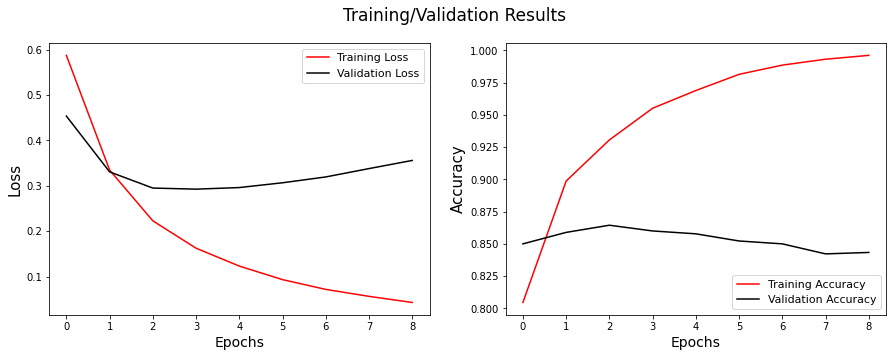

In [ ]:
acc_loss_plot(history3)

#### RNN

In [ ]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
      return K.dot(x, kernel)
      
class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, layers=2, activation='tanh',
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.layers = layers
        self.activation = activation

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.W2_regularizer = regularizers.get(kernel_regularizer)
        self.W3_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)
        self.b3_regularizer = regularizers.get(bias_regularizer)
        self.b4_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.W2_constraint = constraints.get(W_constraint)
        self.W3_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)
        self.b3_constraint = constraints.get(b_constraint)
        self.b4_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.layers in [3,4]:
            self.W2 = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                    initializer=self.init,
                                    name='{}_W2'.format(self.name),
                                    regularizer=self.W2_regularizer,
                                    constraint=self.W2_constraint)
        if self.layers == 4:
            self.W3 = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                    initializer=self.init,
                                    name='{}_W3'.format(self.name),
                                    regularizer=self.W3_regularizer,
                                    constraint=self.W3_constraint)
        
        if self.bias:
            self.b1 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
            if self.layers in [3,4]:
                self.b3 = self.add_weight(shape=(1,),
                                        initializer='zero',
                                        name='{}_b3'.format(self.name),
                                        regularizer=self.b3_regularizer,
                                        constraint=self.b3_constraint)
            if self.layers == 4:
                self.b4 = self.add_weight(shape=(1,),
                                        initializer='zero',
                                        name='{}_b4'.format(self.name),
                                        regularizer=self.b4_regularizer,
                                        constraint=self.b4_constraint)
        else:
            self.b1 = None
            self.b2 = None
            self.b3 = None
            self.b4 = None

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1
        
        if self.activation == 'tanh':
            uit = K.tanh(uit)
        else:
            uit = K.relu(uit)
        
        vit = uit
        
        if self.layers in [3,4]:
            uit2 = dot_product(uit, self.W2)

            if self.bias:
                uit2 += self.b3

            if self.activation == 'tanh':
                uit2 = K.tanh(uit2)
            else:
                uit2 = K.relu(uit2)
            vit = uit2

        if self.layers == 4:
            uit3 = dot_product(uit2, self.W3)

            if self.bias:
                uit3 += self.b4

            if self.activation == 'tanh':
                uit3 = K.tanh(uit3)
            else:
                uit3 = K.relu(uit3)
            vit = uit3
        

        # ait = softmax(Ueij)
        eij = dot_product(vit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
tokenizer = Tokenizer(oov_token='__UNK__')  # Create an instance of the tokenizer
tokenizer.fit_on_texts(X_train)  # tokenize the training set

v_size = len(tokenizer.word_index) + 1  # +1 for the padding 

In [ ]:
len(tokenizer.word_index)

44447

In [ ]:
# Convert the sets to a sequence of unique indices that were attached to each voacabulary words
train_sequences = tokenizer.texts_to_sequences(X_train)
dev_sequences = tokenizer.texts_to_sequences(X_dev)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
sent_lengths = [len(s.split()) for s in X_train]
mean_l_sent = np.mean(sent_lengths)
std_l_sent = np.std(sent_lengths)

max_len = round(mean_l_sent + std_l_sent)

# pad/trim the sentences so that all of them have the same length. The length that was chosen was the mean + the standard deviation of words from all the sentences
train_padded = pad_sequences(train_sequences, maxlen=max_len, truncating='post', padding='post')
dev_padded = pad_sequences(dev_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
def embedding_matrix_creator(tokenizer, embeddings_dict, dim, vsize):  # create an embedding matrix using the pretrained embeddings
    embedding_matrix = np.zeros((v_size, dim))
    missed_words = []
    replaced = []

    for word,i in tokenizer.word_index.items():
        if i < v_size:
            try:
                emb_vec = embeddings_dict[word]
            except:
                if word == '__UNK__':
                    emb_vec = None
                else:
                    for j in range(len(word), 2, -1):  # iterate the word backwards
                        try:
                            emb_vec = embeddings_dict[word[:j]]  # check if the 'smaller' word has an embedding
                            replaced.append(word[:j])
                            break
                        except:
                            emb_vec = None
                    missed_words.append(word)  # count the words that were not found in the embeddings vocabulary
                    
            if emb_vec is not None:
                embedding_matrix[i] = emb_vec
            
    return embedding_matrix, missed_words, replaced

In [ ]:
filename = 'cc.en.300.vec'  # fasttext
f_emb = KeyedVectors.load_word2vec_format(filename)

In [ ]:
embedding_matrix, miss, replaced = embedding_matrix_creator(tokenizer, f_emb, 300, v_size)  # create embeddings matrix

In [ ]:
print(f"{len(miss)} words did not have an embedding. Most of them were replaced by a lower-count ngram. Some of them are:\n")
for i in range(10):
    print(f"Word {miss[i]} was replaced with word {replaced[i]}.\n")

5809 words did not have an embedding. Most of them were replaced by a lower-count ngram. Some of them are:

Word matthau was replaced with word matth.

Word stanwyck was replaced with word stan.

Word fulci was replaced with word ful.

Word rockne was replaced with word rockn.

Word branagh was replaced with word brana.

Word depardieu was replaced with word depar.

Word huppert was replaced with word hup.

Word mitchum was replaced with word mitch.

Word preminger was replaced with word premi.

Word verhoeven was replaced with word verh.



In [ ]:
def build_lstm(hp):

  inputs = Input((max_len,))
  next = Embedding(v_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(inputs)


  next = Dropout(hp.Float("dropout 1", min_value=0, max_value=0.5))(next)


  for i in range(hp.Int("number of LSTM layers", 1, 3)):
    next = Bidirectional(LSTM(units = hp.Int('LSTM nodes', min_value=100, max_value=300, step=100), return_sequences=True, recurrent_dropout = hp.Float("variotonal dropout lstm", min_value=0, max_value=0.5)))(next) 
    if hp.Boolean('Normalization ?'):
      next = LayerNormalization()(next)
    next = Dropout(hp.Float("dropout 2", min_value=0, max_value=0.5))(next)

  
  
  next = DeepAttention(layers=hp.Choice('Attention Layers ?',[2,3,4]), activation=hp.Choice('Attention activation function ?',['relu','tanh']), return_attention=False)(next)
  next = Dropout(hp.Float("dropout 3", min_value=0, max_value=0.5))(next)


  extra_dense = hp.Choice('Extra Dense nodes?',[0,32,64])
  extra_dense_drop = hp.Float("dropout 4?", min_value=0, max_value=0.5)
  if(extra_dense !=0):
    next = Dense(units=extra_dense, activation="relu")(next)
    next = Dropout(extra_dense_drop)(next)


  out = Dense(1, activation='sigmoid')(next)
  model = Model(inputs, out)

  lr = hp.Float("learning rate", min_value=1e-4, max_value=1e-2,sampling='log')
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=build_lstm,
    objective="val_loss",
    max_trials=3,
    num_initial_points=2,
    overwrite=True,
    directory="best_params"
)
tuner.search_space_summary()

Search space summary
Default search space size: 12
dropout 1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
number of LSTM layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
LSTM nodes (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 300, 'step': 100, 'sampling': None}
variotonal dropout lstm (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
Normalization ? (Boolean)
{'default': False, 'conditions': []}
dropout 2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
Attention Layers ? (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Attention activation function ? (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout 3 (Float)
{'default': 0.0, 'cond

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(train_padded, np.array(y_train), epochs=1000, verbose=1, 
                validation_data=(dev_padded, np.array(y_dev)), callbacks=[es], batch_size=128)

Trial 3 Complete [00h 09m 03s]
val_loss: 0.6578664183616638

Best val_loss So Far: 0.3179837167263031
Total elapsed time: 03h 08m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in best_params/untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dropout 1: 0.4689039868634631
number of LSTM layers: 2
LSTM nodes: 200
variotonal dropout lstm: 0.36401422041453746
Normalization ?: False
dropout 2: 0.32162835578120347
Attention Layers ?: 4
Attention activation function ?: relu
dropout 3: 0.41793780561010696
Extra Dense nodes?: 0
dropout 4?: 0.23234270169676097
learning rate: 0.0020312059283255943
Score: 0.3179837167263031
Trial summary
Hyperparameters:
dropout 1: 0.39700854096800964
number of LSTM layers: 3
LSTM nodes: 200
variotonal dropout lstm: 0.3331062445950656
Normalization ?: False
dropout 2: 0.4305711294806757
Attention Layers ?: 4
Attention activation function ?: relu
dropout 3: 0.09318047438980287
Extra Dense nodes?: 0
dropout 4?: 0.4614174714698592
learning rate: 0.000982791737416396
Score: 0.3455426096916199
Trial summary
Hyperparameters:
dropout 1: 0.5
number of LSTM l

In [ ]:
input_w = Input(shape=(max_len,))
embeddings_w = Embedding(v_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input_w)
word_dropout = Dropout(0.4689)(embeddings_w)
bi_lstm = Bidirectional(LSTM(units=200, recurrent_dropout=0.364, return_sequences=True))(word_dropout)
dropout2 = Dropout(0.3216)(bi_lstm)
bi_lstm2 = Bidirectional(LSTM(units=200, recurrent_dropout=0.364, return_sequences=True))(dropout2)
dropout3 = Dropout(0.3216)(bi_lstm2)
attn_layer, attn = DeepAttention(layers=4, activation='relu', return_attention=True)(dropout3)
dropout4 = Dropout(0.41793)(attn_layer)
output = Dense(units=1, activation='sigmoid')(dropout4)

model = Model(input_w, output)

opt = Adam(learning_rate=0.0020312059283255943)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 211)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 211, 300)          13334400  
                                                                 
 dropout_10 (Dropout)        (None, 211, 300)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 211, 400)         801600    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 211, 400)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 211, 400)         961600    
 nal)                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_padded, np.array(y_train), epochs=1000, batch_size=128,
                    validation_data=(dev_padded, np.array(y_dev)), callbacks=[es])

Epoch 1/1000
55/55 [==============================] - 187s 3s/step - loss: 0.5259 - accuracy: 0.7426 - val_loss: 0.4657 - val_accuracy: 0.8067
Epoch 2/1000
55/55 [==============================] - 175s 3s/step - loss: 0.4370 - accuracy: 0.8007 - val_loss: 0.4692 - val_accuracy: 0.7822
Epoch 3/1000
55/55 [==============================] - 175s 3s/step - loss: 0.4211 - accuracy: 0.8104 - val_loss: 0.3869 - val_accuracy: 0.8300
Epoch 4/1000
55/55 [==============================] - 175s 3s/step - loss: 0.3821 - accuracy: 0.8301 - val_loss: 0.3845 - val_accuracy: 0.8278
Epoch 5/1000
55/55 [==============================] - 176s 3s/step - loss: 0.3787 - accuracy: 0.8329 - val_loss: 0.3690 - val_accuracy: 0.8400
Epoch 6/1000
55/55 [==============================] - 174s 3s/step - loss: 0.3633 - accuracy: 0.8393 - val_loss: 0.3627 - val_accuracy: 0.8367
Epoch 7/1000
55/55 [==============================] - 173s 3s/step - loss: 0.3509 - accuracy: 0.8469 - val_loss: 0.3738 - val_accuracy: 0.8400

In [ ]:
model.evaluate(test_padded, y_test)

66/66 [==============================] - 17s 239ms/step - loss: 0.3043 - accuracy: 0.8667


[0.3043007552623749, 0.8666666746139526]

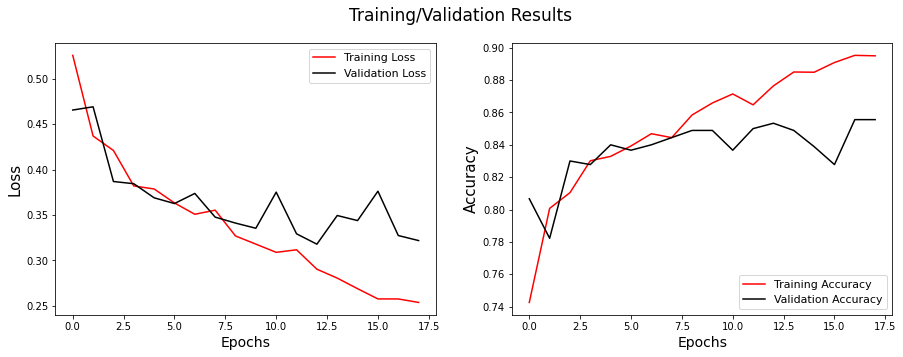

In [ ]:
acc_loss_plot(history)

##### Character Embeddings

In [ ]:
char_ind = {c: i+1 for i,c in enumerate(list(string.ascii_lowercase))}  # create a character-index dictionary

In [ ]:
char_ind.keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

In [ ]:
def sent_to_char_ind(char_ind, sentences, max_len, max_sent_len):
    sent_char_seq = []
    for sent in sentences:  # for each sentence
        word_seq = []
        for word in sent.split():  # for each word
            char_seq = []
            for char in word:  # for each character
                if len(char_seq) < max_len:
                    char_seq.append(char_ind[char])  # append the character's index if the length is smalled than the predifined one
                else:
                    break
            while len(char_seq) < max_len:  # pad if the length is smaller
                char_seq.append(0)
            if len(word_seq) < max_sent_len:
                word_seq.append(char_seq)
        while len(word_seq) < max_sent_len:
            word_seq.append([0 for i in range(max_len)])  # pad the sentences so that all of them have the same length
        sent_char_seq.append(word_seq)
    return sent_char_seq

In [ ]:
char_train = sent_to_char_ind(char_ind, X_train.tolist(), 12, max_len)
char_dev = sent_to_char_ind(char_ind, X_dev.tolist(), 12, max_len)
char_test = sent_to_char_ind(char_ind, X_test.tolist(), 12, max_len)

In [ ]:
np.array(X_test).shape

(2100,)

In [ ]:
input_c = Input(shape=(max_len,12))
embeddings_c = TimeDistributed(Embedding(input_dim=len(char_ind)+1, output_dim=50, 
                                         input_length=12, trainable=True, mask_zero=True))(input_c)
char_lstm = TimeDistributed(Bidirectional(LSTM(units=50, recurrent_dropout=0.2)))(embeddings_c)
char_dropout = Dropout(0.2)(char_lstm)

input_w = Input(shape=(max_len,))
embeddings_w = Embedding(v_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input_w)
word_dropout = Dropout(0.2)(embeddings_w)

concat = concatenate([char_dropout, word_dropout], axis=-1)
bi_lstm = Bidirectional(LSTM(units=200, recurrent_dropout=0.364, return_sequences=True))(concat)
dropout2 = Dropout(0.3216)(bi_lstm)
bi_lstm2 = Bidirectional(LSTM(units=200, recurrent_dropout=0.364, return_sequences=True))(dropout2)
dropout3 = Dropout(0.3216)(bi_lstm2)
attn_layer, attn = DeepAttention(layers=4, activation='relu', return_attention=True)(dropout3)
dropout4 = Dropout(0.41793)(attn_layer)
output = Dense(units=1, activation='sigmoid')(dropout4)

model2 = Model([input_c, input_w], output)

opt = Adam(learning_rate=0.0009)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 211, 12)]    0           []                               
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 211, 12, 50)  1350       ['input_3[0][0]']                
 buted)                                                                                           
                                                                                                  
 input_4 (InputLayer)           [(None, 211)]        0           []                               
                                                                                                  
 time_distributed_3 (TimeDistri  (None, 211, 100)    40400       ['time_distributed_2[0][0]'

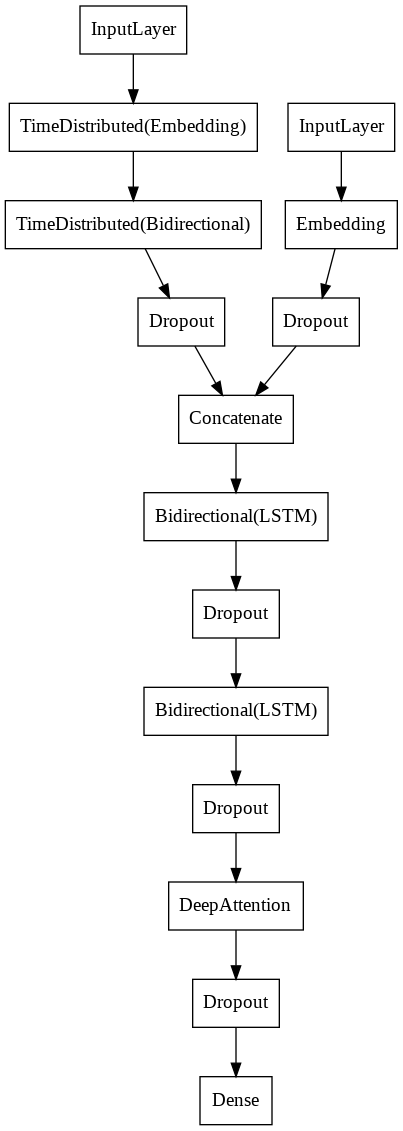

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=False, show_layer_names=False)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model2.fit([np.array(char_train), train_padded], np.array(y_train), epochs=1000, batch_size=128, 
                     validation_data=([np.array(char_dev), dev_padded], np.array(y_dev)), callbacks=[es])

Epoch 1/1000
55/55 [==============================] - 213s 4s/step - loss: 0.5381 - accuracy: 0.7231 - val_loss: 0.4699 - val_accuracy: 0.7889
Epoch 2/1000
55/55 [==============================] - 192s 3s/step - loss: 0.4407 - accuracy: 0.8010 - val_loss: 0.4137 - val_accuracy: 0.8144
Epoch 3/1000
55/55 [==============================] - 190s 3s/step - loss: 0.3850 - accuracy: 0.8260 - val_loss: 0.4071 - val_accuracy: 0.8122
Epoch 4/1000
55/55 [==============================] - 187s 3s/step - loss: 0.3879 - accuracy: 0.8289 - val_loss: 0.4089 - val_accuracy: 0.8178
Epoch 5/1000
55/55 [==============================] - 189s 3s/step - loss: 0.3605 - accuracy: 0.8409 - val_loss: 0.4146 - val_accuracy: 0.8156
Epoch 6/1000
55/55 [==============================] - 189s 3s/step - loss: 0.3354 - accuracy: 0.8504 - val_loss: 0.3738 - val_accuracy: 0.8311
Epoch 7/1000
55/55 [==============================] - 207s 4s/step - loss: 0.3346 - accuracy: 0.8556 - val_loss: 0.3866 - val_accuracy: 0.8178

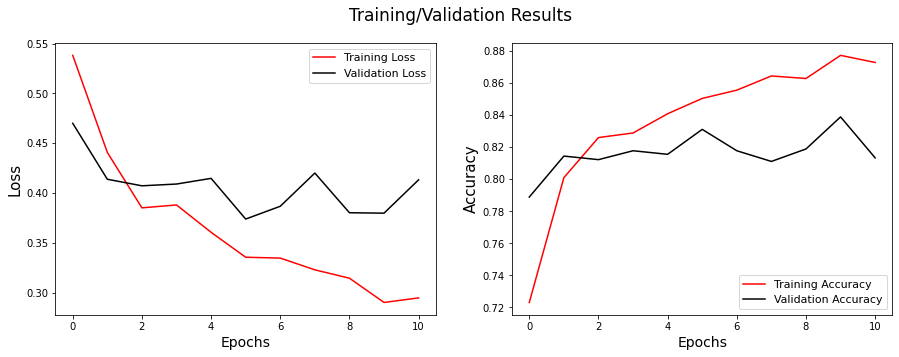

In [ ]:
acc_loss_plot(history)

In [ ]:
model2.evaluate([np.array(char_test),test_padded], np.array(y_test))

66/66 [==============================] - 18s 275ms/step - loss: 0.3489 - accuracy: 0.8400


[0.3489031195640564, 0.8399999737739563]

#### Score tables

In [ ]:
def score_func(model, X_test, y_test, lr=False):
    """
    calculates and returns a dictionary with all the prediction scores
    """
    scores = {}
    
    if not lr:
        yhat = np.where(model.predict(X_test) > 0.5, 1, 0).reshape(-1,)
        y_probs = model.predict(X_test)
    else:
        yhat = model.predict(X_test)
        y_probs = model.predict_proba(X_test)
    
    scores['Accuracy'] = accuracy_score(y_test, yhat)
    scores['Recall0'] = recall_score(y_test, yhat, average=None, labels=[0])[0]
    scores['Recall1'] = recall_score(y_test, yhat, average=None, labels=[1])[0]
    scores['Recall_macro'] = recall_score(y_test, yhat, average='macro')
    scores['Precision0'] = precision_score(y_test, yhat, average=None, labels=[0])[0]
    scores['Precision1'] = precision_score(y_test, yhat, average=None, labels=[1])[0]
    scores['Precision_macro'] = precision_score(y_test, yhat, average='macro')
    scores['F1_0'] = f1_score(y_test, yhat, average=None, labels=[0])[0]
    scores['F1_1'] = f1_score(y_test, yhat, average=None, labels=[1])[0]
    scores['F1_macro'] = f1_score(y_test, yhat, average='macro')

    if not lr:
        scores['AUC0'] = average_precision_score(y_test, 1 - y_probs, pos_label = 0, average=None)
        scores['AUC1'] = average_precision_score(y_test, y_probs, pos_label = 1, average=None)
        scores['AUC_macro'] = average_precision_score(y_test, y_probs)
    else:
        scores['AUC0'] = average_precision_score(y_test, y_probs[:,0], pos_label = 0, average=None)
        scores['AUC1'] = average_precision_score(y_test, y_probs[:,1], pos_label = 1, average=None)
        scores['AUC_macro'] = average_precision_score(y_test, y_probs[:,1])
    
    return scores

In [ ]:
m1_test_scores = score_func(model, test_padded, np.array(y_test))
m1_dev_scores = score_func(model, dev_padded, np.array(y_dev))
m1_train_scores = score_func(model, train_padded, np.array(y_train))

m2_test_scores = score_func(model2, [np.array(char_test),test_padded], np.array(y_test))
m2_dev_scores = score_func(model2, [np.array(char_dev),dev_padded], np.array(y_dev))
m2_train_scores = score_func(model2, [np.array(char_train),train_padded], np.array(y_train))

m3_test_scores = score_func(model3, X_test_tfidf.todense(), np.array(y_test))
m3_dev_scores = score_func(model3, X_dev_tfidf.todense(), np.array(y_dev))
m3_train_scores = score_func(model3, X_train_tfidf.todense(), np.array(y_train))

lr_test_scores = score_func(lr, X_test, np.array(y_test), lr=True)
lr_dev_scores = score_func(lr, X_dev, np.array(y_dev), lr=True)
lr_train_scores = score_func(lr, X_train, np.array(y_train), lr=True)

In [ ]:
def scores_table(dictionaries):
    """
    -arg 'dictionaries' must be a list of dictionaries, where the first dictionary is the training scores,\n
    the second dictionary must be the development scores and the last dictionary the test scores
    """
    dict = {}
    for k in list(dictionaries[0].keys()):
        dict[k] = list(d[k] for d in dictionaries)
    
    df = pd.DataFrame.from_dict(dict, orient='index').rename(columns={0:'Training Set', 1: 'Development Set', 2:'Test Set'})
    return df

In [ ]:
model1_scores = scores_table([m1_train_scores, m1_dev_scores, m1_test_scores])
model2_scores = scores_table([m2_train_scores, m2_dev_scores, m2_test_scores])
model3_scores = scores_table([m3_train_scores, m3_dev_scores, m3_test_scores])
lr_scores = scores_table([lr_train_scores, lr_dev_scores, lr_test_scores])

In [ ]:
model1_scores

,Training Set,Development Set,Test Set
Accuracy,0.913429,0.853333,0.866667
Recall0,0.887991,0.817972,0.841957
Recall1,0.938348,0.886266,0.891996
Recall_macro,0.913170,0.852119,0.866976
Precision0,0.933819,0.870098,0.888779
Precision1,0.895305,0.839431,0.846295
Precision_macro,0.914562,0.854764,0.867537
F1_0,0.910328,0.843230,0.864734
F1_1,0.916321,0.862213,0.868545
F1_macro,0.913325,0.852722,0.866639


In [ ]:
model2_scores

,Training Set,Development Set,Test Set
Accuracy,0.875000,0.831111,0.840000
Recall0,0.837760,0.813364,0.807150
Recall1,0.911482,0.847639,0.873674
Recall_macro,0.874621,0.830502,0.840412
Precision0,0.902644,0.832547,0.867543
Precision1,0.851519,0.829832,0.815482
Precision_macro,0.877082,0.831190,0.841512
F1_0,0.868992,0.822844,0.836257
F1_1,0.880481,0.838641,0.843575
F1_macro,0.874737,0.830743,0.839916


In [ ]:
model3_scores

,Training Set,Development Set,Test Set
Accuracy,0.976714,0.860000,0.889048
Recall0,0.982102,0.880184,0.902164
Recall1,0.971437,0.841202,0.875603
Recall_macro,0.976769,0.860693,0.888883
Precision0,0.971168,0.837719,0.881434
Precision1,0.982271,0.882883,0.897233
Precision_macro,0.976719,0.860301,0.889334
F1_0,0.976604,0.858427,0.891678
F1_1,0.976824,0.861538,0.886286
F1_macro,0.976714,0.859983,0.888982


In [ ]:
lr_scores

,Training Set,Development Set,Test Set
Accuracy,0.907429,0.857778,0.867619
Recall0,0.882794,0.827189,0.845720
Recall1,0.931561,0.886266,0.890068
Recall_macro,0.907178,0.856728,0.867894
Precision0,0.926667,0.871359,0.887463
Precision1,0.890270,0.846311,0.849126
Precision_macro,0.908468,0.858835,0.868295
F1_0,0.904199,0.848700,0.866089
F1_1,0.910448,0.865828,0.869115
F1_macro,0.907323,0.857264,0.867602
